In [1]:
import numpy as np 
import pandas as pd
import torch

In [2]:
dataset = pd.read_csv('Parsed_data.csv')

In [3]:
dataset.head()

,img_path,age
0,C:\Users\zanzi\Desktop\Python\LAG_dataset\data...,y
1,C:\Users\zanzi\Desktop\Python\LAG_dataset\data...,y
2,C:\Users\zanzi\Desktop\Python\LAG_dataset\data...,y
3,C:\Users\zanzi\Desktop\Python\LAG_dataset\data...,y
4,C:\Users\zanzi\Desktop\Python\LAG_dataset\data...,a


In [4]:
img_paths = np.asarray(dataset.img_path)
labels = np.asarray(dataset.age)

In [5]:
labels[labels=='y'] = 0
labels[labels=='a'] = 1

In [6]:
labels

array([0, 0, 0, ..., 1, 0, 1], dtype=object)

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

In [8]:
images = {}

In [9]:
ind = 0
for img_path in img_paths:
    img = np.asarray(Image.open(img_path))
    images[ind] = img
    ind+=1
    

In [10]:
images = list(images.values()) 

In [11]:
images = np.asarray(images)

In [12]:
images.shape

(3828, 100, 100, 3)

In [13]:
labels.shape

(3828,)

In [14]:
from sklearn import preprocessing

In [15]:
images = preprocessing.scale(images.reshape(images.shape[0],-1), axis=1).reshape(images.shape[0], 100,100,3)

In [16]:
images = torch.FloatTensor(images).reshape(-1,3,100,100)
labels = torch.LongTensor(list(labels))
train_size = int(0.75 * images.shape[0])
train_X = images[:train_size]
train_y = labels[:train_size]

test_X = images[train_size:]
test_y = labels[train_size:]

In [17]:
train_y

tensor([0, 0, 0,  ..., 0, 1, 0])

In [18]:
train_X.shape[0] + test_X.shape[0]

3828

In [19]:
from torch import nn
from torch.nn import functional as F 

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [163]:
class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_lay_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.poop_lay = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv_lay_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
    
        self.line_lay_1 = nn.Linear(9*9*64, 600)
        self.line_lay_2 = nn.Linear(600, 300)
        self.line_lay_3 = nn.Linear(300, 150)
        self.line_lay_4 = nn.Linear(150, 2)
        
    def forward(self, X):
        X = self.poop_lay(F.relu(self.conv_lay_1(X)))
        X = self.poop_lay(F.relu(self.conv_lay_2(X)))
        
        X = X.reshape(-1, 9*9*64)
        X = F.relu(self.line_lay_1(X))
        X = F.relu(self.line_lay_2(X))
        X = F.relu(self.line_lay_3(X))
        X = self.line_lay_4(X)
        return X

In [164]:
torch.cuda.empty_cache()

In [165]:
model = ConvModel().to(device)

In [166]:
batch_size = 128
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 30
count_of_batchs = int(train_X.shape[0]/batch_size)

In [167]:
import tqdm.notebook as tq 

In [168]:
torch.cuda.empty_cache()
loss_history = []
for epoch in tq.tqdm(range(epochs)):
    cur_loss = 0
    for i in range(count_of_batchs):
        batch_X = train_X[i*batch_size:(i+1)*batch_size]
        batch_y = train_y[i*batch_size:(i+1)*batch_size]
        probs = model.forward(batch_X.to(device))
        
        loss = loss_fn(probs, batch_y.to(device))
        
        cur_loss += loss.item()
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    print(cur_loss)
    loss_history.append(cur_loss)   

  0%|          | 0/30 [00:00<?, ?it/s]

15.416892886161804
13.540590822696686
12.555283069610596
12.026736617088318
11.695720911026001
11.203270047903061
10.867976278066635
10.345122635364532
10.638108879327774
10.314409703016281
9.74077621102333
8.998245030641556
8.849115490913391
8.612883687019348
9.048623502254486
9.298141419887543
8.065768271684647
8.260216385126114
8.487103328108788
7.727219104766846
7.041622534394264
6.417525559663773
5.842576235532761
7.39388133585453
6.290375918149948
5.105632916092873
4.8587707206606865
5.694572761654854
5.79726268351078
6.118129909038544


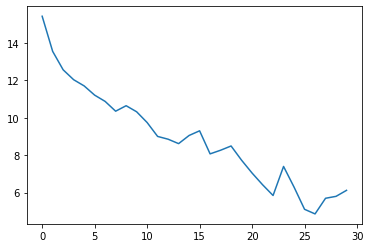

In [169]:
plt.plot(loss_history)

In [161]:
model.cpu()
count_of_batchs = int(test_X.shape[0]/batch_size)
with torch.no_grad():
    acc = []
    for i in tq.tqdm(range(count_of_batchs)):
        batch_X = test_X[i*batch_size:(i+1)*batch_size]
        batch_y = test_y[i*batch_size:(i+1)*batch_size]
        probs = model.forward(batch_X)
        prediction = np.argmax(probs, axis=1)
        acc.append(torch.sum(prediction == batch_y)/batch_y.shape[0])
    acc = np.mean(acc)
    

  0%|          | 0/7 [00:00<?, ?it/s]

In [162]:
acc

0.68973213